In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn-v0_8-colorblind")

In [44]:
def isolateFuncGroups(df):
    colList = [x for x in df.columns if "fr_" in x]
    print(len(colList), "functional group columns found")

    fgData = df[colList]
    fgData.insert(0, "InChI", df["InChI"])
    fgData.insert(1, "MolWt", df["MolWt"])

    fgData = fgData.sort_values(by="MolWt", ascending=False)
    fgData.reset_index(drop=True, inplace=True)
    return fgData

def funcGroupStats(data):
    del data["MolWt"]
    stats = data.describe().T
    del stats["count"]
    stats = stats.sort_values(by="max", ascending=False)
    
    noFuncGroups = stats[stats["max"] == 0]

    return stats, noFuncGroups

def nonZeroCount(stats, data):
    funcGroups = stats.index
    nVals  = len(data)
    nonZero = {}

    for fg in funcGroups:
        colVals = data[fg].values
        nonZeroLen = len(colVals[colVals > 0])
        nonZeroPerc = np.around((nonZeroLen / nVals) * 100, 2)
        nonZero[fg] = nonZeroLen, nonZeroPerc
    
    return nonZero

def plotFuncGroupStats(stats, data, dataset):
    top10Funcs = stats["numNonZero"].head(10)
    fgDist = data[top10Funcs.index[0]]
    fgDist = fgDist[fgDist > 0]

    fig, axes = plt.subplots(2, 2, figsize = (11.7, 8.3), layout = "constrained", dpi=300)
    ax0, ax1, ax2, ax3 = axes.flatten()

    ax0.bar(top10Funcs.index, top10Funcs.values)
    ax0.set_xticklabels(top10Funcs.index, rotation=90)
    ax0.set_title("Number of non-zero occurrences")

    ax0.set_ylabel("Count")
    ax0.set_xlabel("Fragment")

    ax1.hist(fgDist, bins=15, histtype="bar", edgecolor="black")
    ax1.set_title(f"Distribution of {top10Funcs.index[0]}")
    ax1.set_ylabel("Frequency")
    ax1.set_xlabel("Number of non zero occurances in molecule")

    top10Funcs = stats["percNonZero"].head(10)
    tab = ax2.table(cellText=top10Funcs.values.reshape(-1, 1), rowLabels=top10Funcs.index, colLabels=["Percentage"], loc="center", cellLoc="center")
    ax2.axis("off")
    tab.auto_set_font_size(False)
    tab.auto_set_column_width(col=list(range(len(top10Funcs))))

    fig.delaxes(ax3)

    plt.suptitle(f"Top 10 functional groups in {dataset}", fontsize=16, weight="bold")
    plt.savefig(f"../Results/FuncGroupAnalysis/{dataset.replace(" ", "_")}_top10FuncGroups.png")
    plt.close()

In [45]:
datasets = {"Master" : "Combined/0.5.0-Master+RDKit.csv",
            "Solubility" : "Datasets/0.7.1-onlyLogS.csv",
            "Henry's Law Constant" : "Datasets/0.7.1-onlyLogH.csv",
            "Solubility and Henry's Law Constant (Test Set)" : "Datasets/0.7.1-logHlogS.csv"}

dsetKeys = list(datasets.keys())
zeroCols = {}
statsList = {}

for key in dsetKeys:
    df = pd.read_csv(f"../Data/{datasets[key]}")
    fgData = isolateFuncGroups(df)
    stats, noFuncGroups = funcGroupStats(fgData)
    nonZero = nonZeroCount(stats, fgData)

    zeroCols[key] = noFuncGroups.index
    statsList[key] = stats

    indexList = stats.index
    nonZeroCol = []
    nonZeroPerc = []

    for i in indexList:
        nonZeroCol.append(nonZero[i][0])
        nonZeroPerc.append(nonZero[i][1])

    stats.insert(1, "numNonZero", nonZeroCol)
    stats.insert(2, "percNonZero", nonZeroPerc)
    stats = stats.sort_values(by="numNonZero", ascending=False)

    fgData.to_csv(f"../Results/FuncGroupAnalysis/{key.replace(" ", "_")}-FuncGroups.csv", index=False)
    stats.to_csv(f"../Results/FuncGroupAnalysis/{key.replace(" ", "_")}-FuncGroupStats.csv", index=True)
    noFuncGroups.to_csv(f"../Results/FuncGroupAnalysis/{key.replace(" ", "_")}-NoFuncGroups.csv", index=True)

    plotFuncGroupStats(stats, fgData, key)

85 functional group columns found


C:\Users\josh_\AppData\Local\Temp\ipykernel_38876\1231957012.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(top10Funcs.index, rotation=90)


85 functional group columns found


C:\Users\josh_\AppData\Local\Temp\ipykernel_38876\1231957012.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(top10Funcs.index, rotation=90)


85 functional group columns found


C:\Users\josh_\AppData\Local\Temp\ipykernel_38876\1231957012.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(top10Funcs.index, rotation=90)


85 functional group columns found


C:\Users\josh_\AppData\Local\Temp\ipykernel_38876\1231957012.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(top10Funcs.index, rotation=90)


In [46]:
zColKeys = list(zeroCols.keys())
for key in zColKeys:
    print(key, len(zeroCols[key]))

hl = zeroCols["Henry's Law Constant"]
sol = zeroCols["Solubility"]
test = zeroCols["Solubility and Henry's Law Constant (Test Set)"]
master = zeroCols["Master"]

print(hl.difference(sol))

print(test.difference(sol)) #things that are in the test set but not in the solubility set
print(test.difference(hl))
print("stuff that has no entries in the test set but has entries in the master", test.difference(master))

Master 24
Solubility 24
Henry's Law Constant 28
Solubility and Henry's Law Constant (Test Set) 28
Index(['fr_alkyl_carbamate', 'fr_azide', 'fr_diazo', 'fr_isothiocyan'], dtype='object')
Index(['fr_alkyl_carbamate', 'fr_diazo', 'fr_isocyan', 'fr_lactam'], dtype='object')
Index(['fr_isocyan', 'fr_lactam'], dtype='object')
stuff that has no entries in the test set but has entries in the master Index(['fr_alkyl_carbamate', 'fr_diazo', 'fr_isocyan', 'fr_lactam'], dtype='object')


In [96]:
top10s = {}
top10sList = []
for stats in statsList:
    subdf = statsList[stats]
    subdf = pd.DataFrame(subdf["percNonZero"])
    subdf.rename(columns={"percNonZero" : f"Percentage-{stats}"}, inplace=True)

    subdf.insert(0, f"Dataset-{stats}", [stats] * len(subdf))
    top10s[stats] = subdf
    top10sList.append(top10s[stats])

top10sDF = pd.concat(top10sList, axis=1)

PercentagesOnly = top10sDF.drop(columns=[x for x in top10sDF.columns if "Dataset" in x])
RankingsOnly = top10sDF.drop(columns=[x for x in top10sDF.columns if "Percentage" in x])

In [97]:
PercentagesOnly.sort_values(by="Percentage-Master", ascending=False, inplace=True)
PercentagesOnly

,Percentage-Master,Percentage-Solubility,Percentage-Henry's Law Constant,Percentage-Solubility and Henry's Law Constant (Test Set)
fr_allylic_oxid,48.16,59.65,34.04,59.93
fr_C_O,41.75,53.83,34.52,25.67
fr_C_O_noCOO,35.46,42.25,33.02,20.44
fr_Al_OH,31.92,38.88,28.01,19.94
fr_NH0,29.96,42.65,18.27,26.65
...,...,...,...,...
fr_prisulfonamd,0.00,0.00,0.00,0.00
fr_tetrazole,0.00,0.00,0.00,0.00
fr_diazo,0.00,0.01,0.00,0.00
fr_alkyl_carbamate,0.00,0.01,0.00,0.00


# Create dictionary

C:\Users\josh_\AppData\Local\Temp\ipykernel_38876\2868313217.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PercentagesOnly.rename(columns={x : x.split("-")[1] for x in PercentagesOnly.columns}, inplace=True)


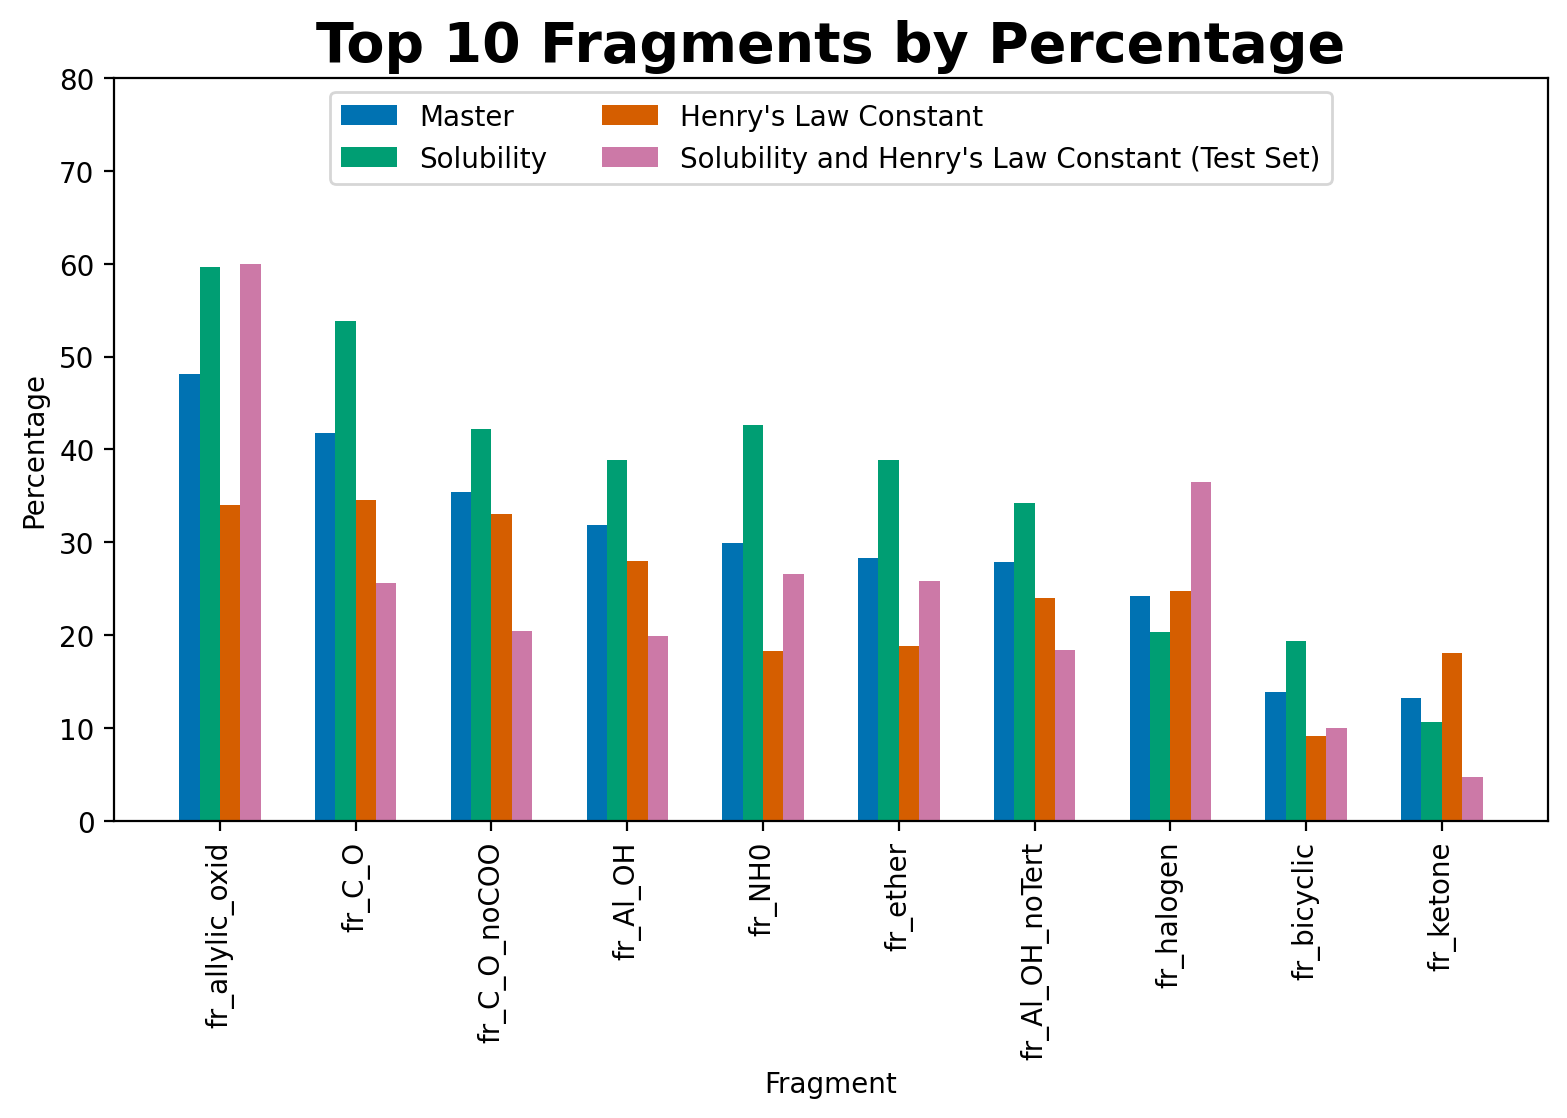

In [98]:
percDict = {}
PercentagesOnly = PercentagesOnly.iloc[0:10, :]
if "-" in PercentagesOnly.columns[0]:
    PercentagesOnly.rename(columns={x : x.split("-")[1] for x in PercentagesOnly.columns}, inplace=True)
indexList = PercentagesOnly.index
colList = PercentagesOnly.columns

for i in colList:
    values = PercentagesOnly[i].values
    percDict[i] = PercentagesOnly[i].values.astype(float).tolist()

x = np.arange(len(indexList))
keys = list(percDict.keys())
width = 0.15
multiplier = 0

fig, ax = plt.subplots(layout = "constrained", dpi = 200, figsize = (11.7*.66, 8.3*.66))
for key, val in percDict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, val, width, label=key)
    multiplier += 1

ax.set_ylabel("Percentage")
ax.set_xlabel("Fragment")
ax.set_title("Top 10 Fragments by Percentage", fontsize=20, weight="bold")
ax.set_xticks(x + 1.5*width, indexList, rotation=90)
ax.set_ylim(0, 80)
ax.legend(loc = "upper center", ncol=2)
plt.show()